# AutoEncoder 실습

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as T
from torchsummary import summary

import tensorflow as tf

In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

In [3]:
device = 'mps'

# Data

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [5]:
train_images[0].shape

(28, 28)

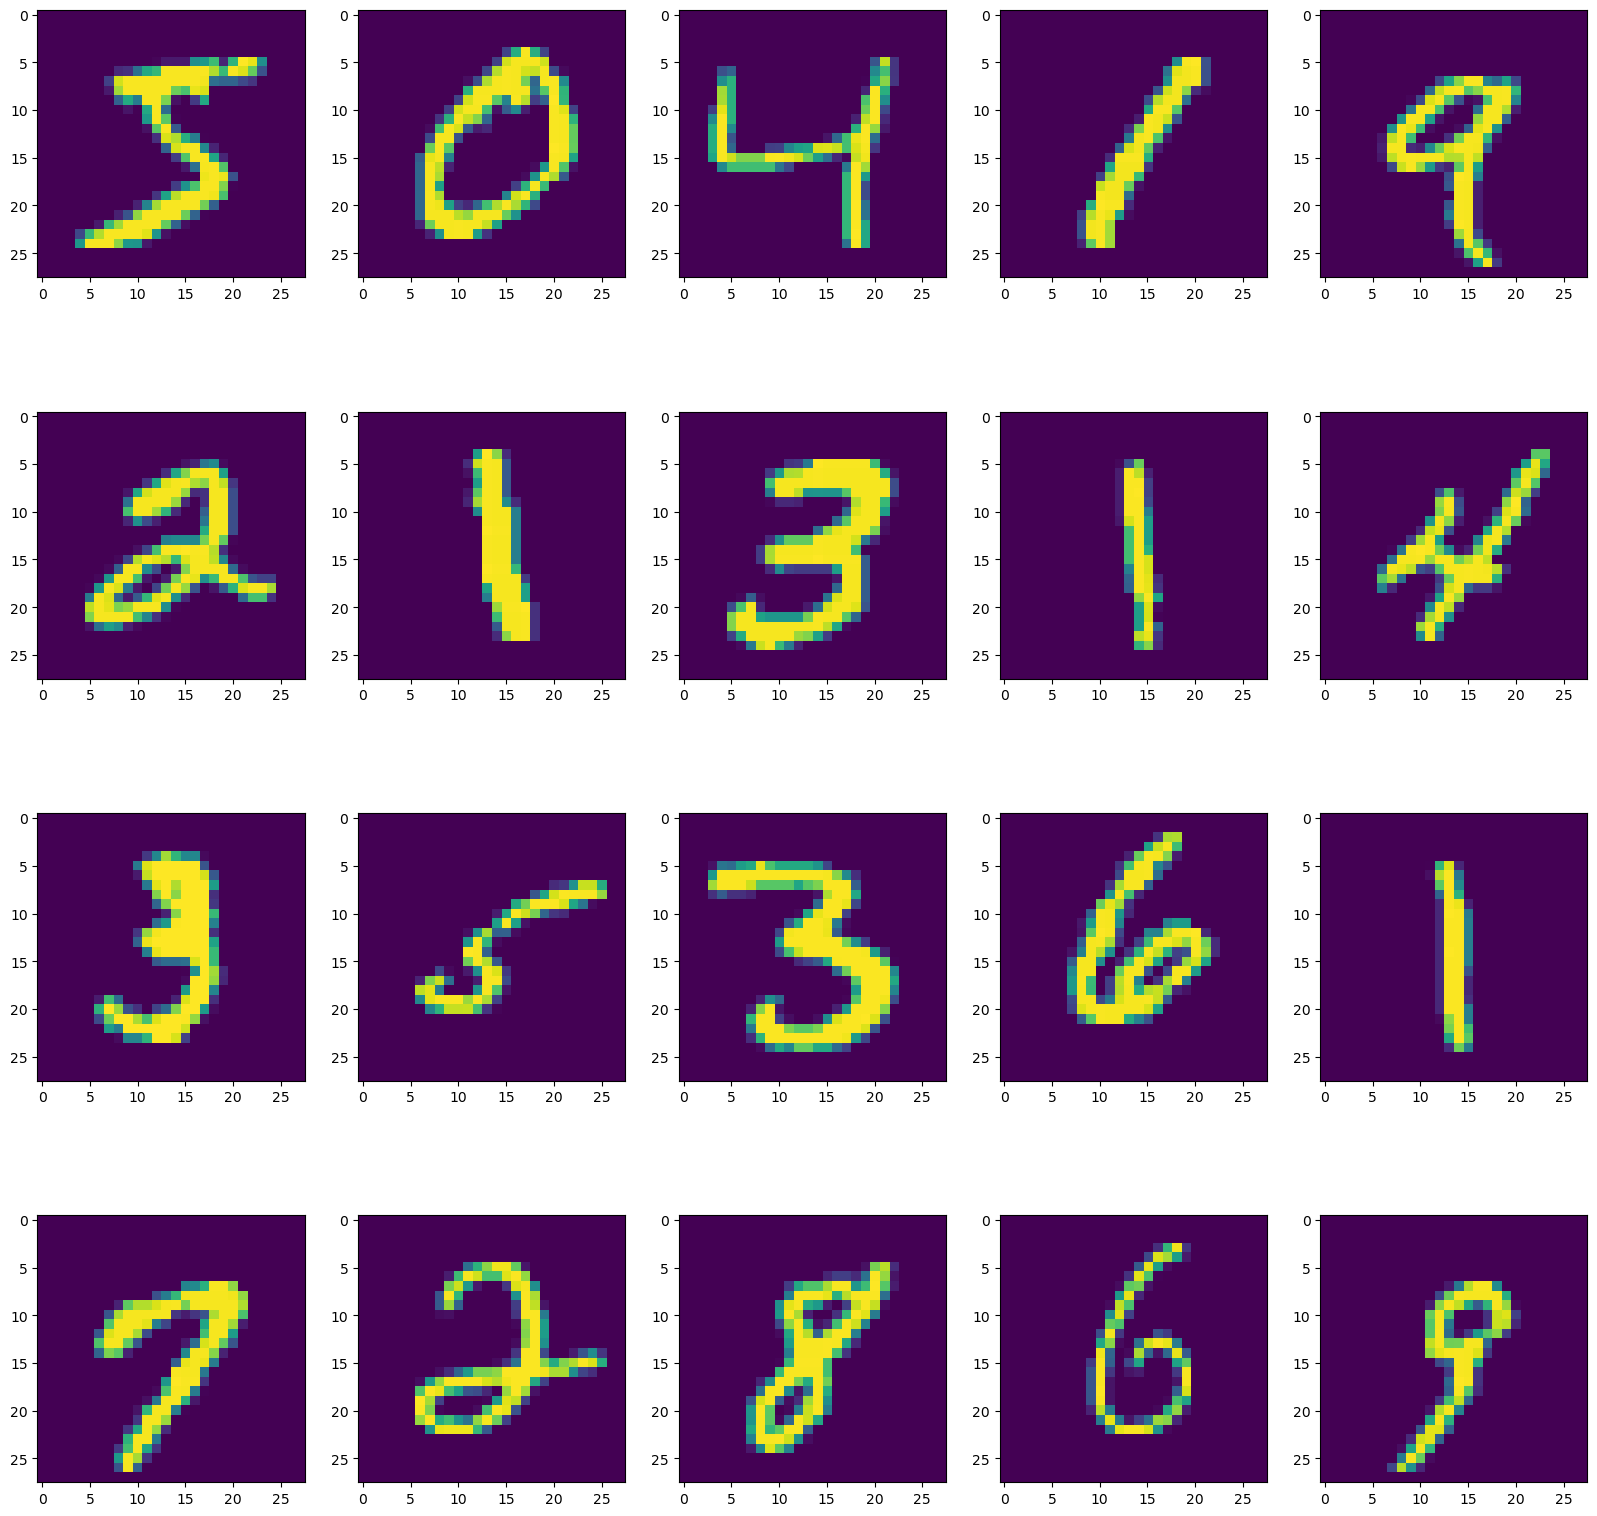

In [6]:
plt.figure(figsize=(20, 20))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(train_images[i])

# Custom Dataset

In [7]:
class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transforms):
        super().__init__()
        self.data = list((transforms(image), label) for image, label in zip(images, labels))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [8]:
transforms = T.Compose([T.ToTensor()])

train_dataset = custom_dataset(train_images, train_labels, transforms)
test_dataset = custom_dataset(test_images, test_labels, transforms)

In [9]:
train_dataset[0][0].squeeze().shape

torch.Size([28, 28])

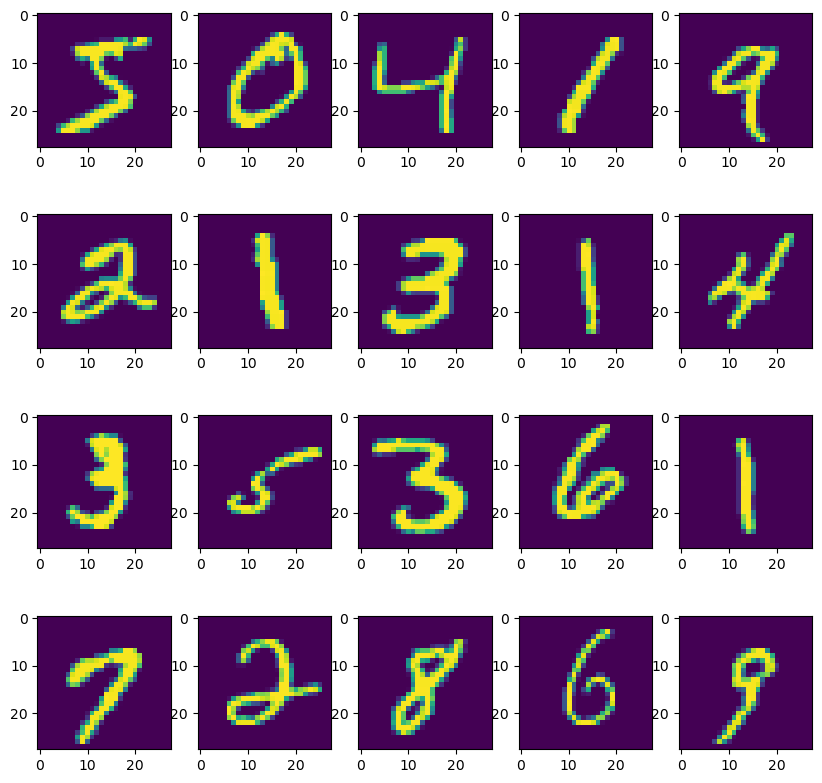

In [10]:
plt.figure(figsize=(10, 10))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(train_dataset[i][0].squeeze())

In [11]:
total_num = len(train_dataset)
train_num, valid_num = int(total_num*0.8), int(total_num*0.2)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

In [12]:
batch_size = 1000

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

# AutoEncoder Model

In [13]:
class autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=32*28*28, out_features=1024),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=1024, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=256, out_features=64),
            torch.nn.ReLU()
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=64, out_features=128),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=128, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=256, out_features=28*28)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        output = decoded.view(-1, 1, 28, 28)
        
        return encoded, decoded, output

# train, valid 함수

In [14]:
def training(model, train_dataloader, train_dataset, optimizer, criterion, epoch, num_epochs):
    model.train()
    train_loss = 0.0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)

        encoded, decoded, output = model(images)
        loss = criterion(decoded, images.view(-1, 28*28))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)

    return model, train_loss

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    
    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)

            encoded, decoded, output = model(images)
            loss = criterion(decoded, images.view(-1, 28*28))

            valid_loss += loss.item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

        valid_loss = valid_loss / len(valid_dataloader)

    return model, valid_loss

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, optimizer, criterion, num_epochs):
    model.to(device)

    for epoch in range(num_epochs):
        model, train_loss = training(model, train_dataloader, train_dataset, optimizer, criterion, epoch, num_epochs)
        model, valid_loss = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        print(train_loss, valid_loss)

    return model

# 학습

In [15]:
model = autoencoder()
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
       BatchNorm2d-5           [-1, 32, 28, 28]              64
              ReLU-6           [-1, 32, 28, 28]               0
           Flatten-7                [-1, 25088]               0
            Linear-8                 [-1, 1024]      25,691,136
              ReLU-9                 [-1, 1024]               0
           Linear-10                  [-1, 256]         262,400
             ReLU-11                  [-1, 256]               0
           Linear-12                   [-1, 64]          16,448
             ReLU-13                   [-1, 64]               0
           Linear-14                  [

In [18]:
# 저장할 Convolution Layer의 이름(module name)에 대한 list도 정의해 줍니다.
# ResNet18에는 총 17개의 convolution layer가 존재합니다.
conv_layers = []

# 모델을 구성하고 있는 하위 모듈들(model.children)을 구합니다.
model_children = list(model.children())
print(len(model_children))

# counter는 저장한 Convolution Layer의 개수를 세기 위해서 정의해 줍니다.
counter = 0

# 모델을 구성하는 Layer들 중 nn.Conv2d 레이어들의 이름을 저장해 줍니다.
for i in range(len(model_children)):
    if type(model_children[i]) == torch.nn.Conv2d:
        counter+=1
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == torch.nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == torch.nn.Conv2d:
                    counter+=1
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")

2
Total convolution layers: 0


In [23]:
model_children = list(model.children())
print(len(model_children))

conv_layer = []
cnt = 0

for i in range(len(model_children)):
    if type(model_children[i]) == torch.nn.Conv2d:
        cnt += 1
        conv_layer.append(model_children[i])

    elif type(model_children[i]) == torch.nn.Sequential:
        for j in range(len(model_children[i])):
            if type(model_children[i][j]) == torch.nn.Conv2d:
                cnt += 1
                conv_layer.append(model_children[i][j])

print(cnt)

2
2


In [28]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, optimizer, criterion, 10)

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

0.06811113151100774 0.049914082822700344


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

0.04157861632605394 0.03497374306122462


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

0.031701278019075595 0.028772220170746248


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

0.027219003027615447 0.026084835330645244


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

0.024667990238716204 0.024770393191526335


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

0.022982350511786837 0.022214913740754128


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

0.021711376767295103 0.021036006199816864


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

0.02090078479765604 0.02058493858203292


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

0.019891825038939714 0.01933458602676789


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

0.019155719317495823 0.018883497609446447


# test

In [47]:
model.eval()
model.to(device)

total_decoded = []
total_outputs = []
total_images = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)

        encoded, decoded, output = model(images)
        total_images.extend(images)
        total_decoded.extend(decoded)
        total_outputs.extend(output)

  0%|          | 0/10 [00:00<?, ?it/s]

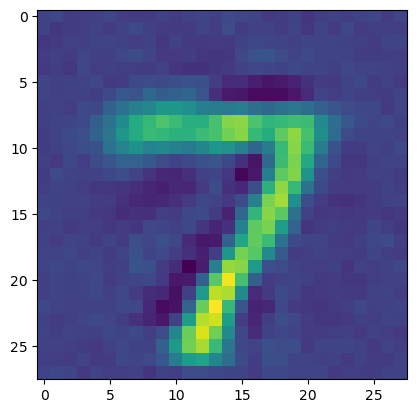

In [48]:
plt.imshow(np.array(total_outputs[0].squeeze().cpu()))

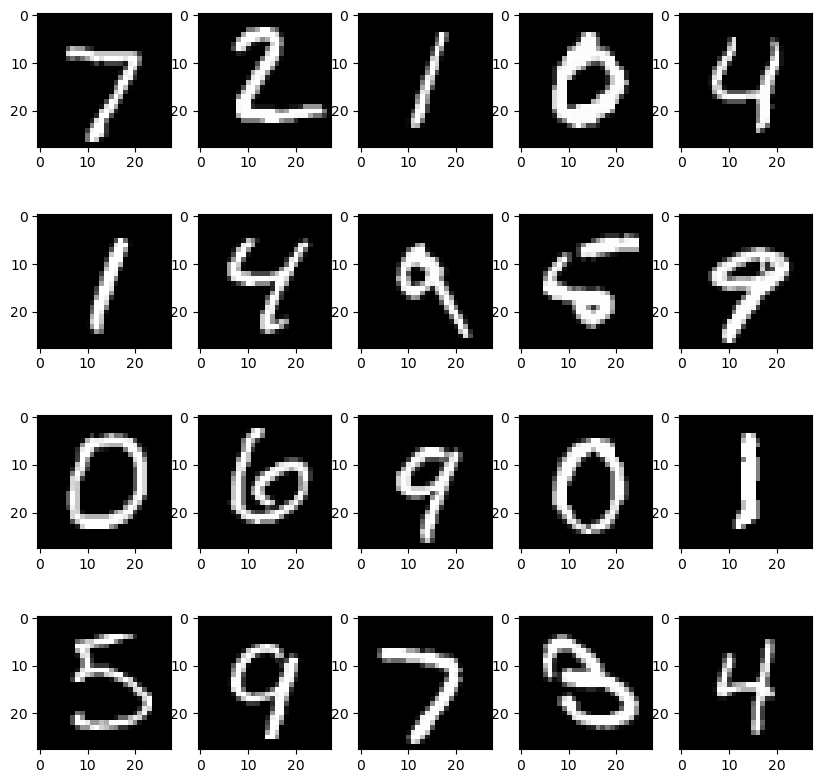

In [50]:
plt.figure(figsize=(10, 10))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(total_images[i].squeeze().cpu()), cmap='gray')

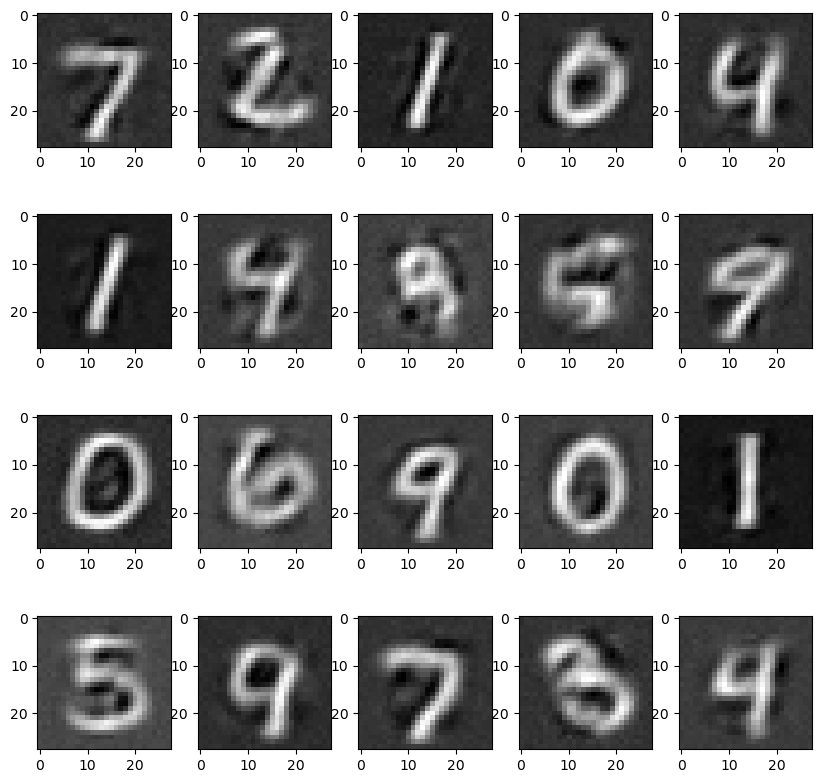

In [46]:
plt.figure(figsize=(10, 10))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(total_outputs[i].squeeze().cpu()), cmap='gray')